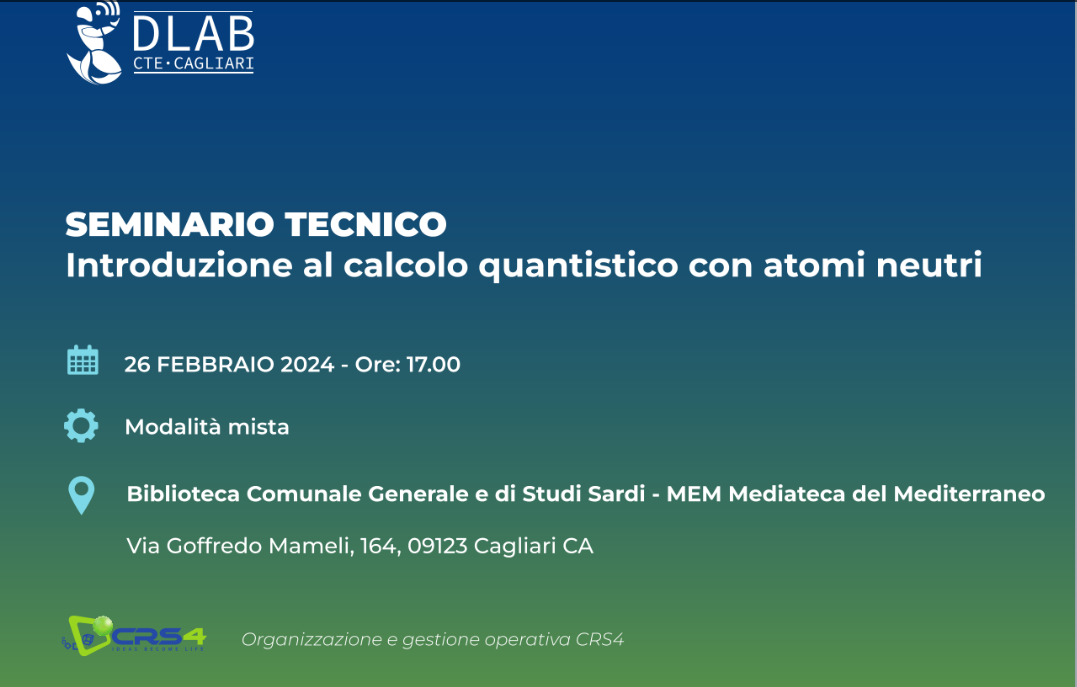

_Crediti: Il presente notebook è stato redatto da Manuela Profir e Giuliana Siddi Moreau sulla base del materiale didattico predisposto da Quera Inc. nella repository https://github.com/QuEraComputing/quera-education e sulla base delle lezioni online impartite da Pedro Lopes nel programma globale Womanium Quantum 2023_

# Esercitazione pratica

In questa esercitazione metteremo in pratica le informazioni acquisite fin'ora. 

Le simulazioni quantistiche su un emulatore analogico con atomi neutri seguono tipicamente un workflow che consiste in 5 passi:

1. Definire le posizioni dei qubit
2. Definire l'algoritmo, cioè l'evoluzione in tempo dei parametri della Hamiltoniana 
3. Inizializzare il problema, cioè inizializzare il registro dei qubit e la Hamiltoniana
4. Realizzare l’evoluzione temporale (l’equivalente della composizione delle porte della computazione digitale)
5. Misurare i risultati

Questi passi servono a collocare i qubit secondo le loro naturali interazioni, controllate dalla Hamiltoniana che può essere vista come una funzione costo che controlla tutte le energie del sistema.  


$$
\mathcal{H} = \sum_j \frac{\Omega(t)}{2} \left( e^{i \phi(t) } | 0_j \rangle  \langle 1_j | + e^{-i \phi(t) } | 1_j \rangle  \langle 0_j | \right) - \sum_j \Delta(t) \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j \hat{n}_k,
$$

dove $| 0_i \rangle,$  $| 1_i \rangle,$ e $\hat{n}_i= 0*|0_i \rangle  \langle 0_i | + 1*| 1_i \rangle  \langle 1_i | $  indicano i qubit nella posizione $i$. 

Il primo passo che deve fare l'utente è quello di definire
geometricamente (in micrometri per Bloqade), quali sono le posizioni accettabili dei qubit. 
Bloqade accetta geometrie 2D arbitrarie, secondo i vincoli dei processori quantistici reali esistenti attualmente. 

Fissare queste posizioni geometriche è fondamentale perché le interazioni 𝑉𝑗𝑘 tra qubit decadono con la distanza tra i qubit alla sesta potenza, $V_{jk} = d_{jk}^{-6}$. Questa interazione impartisce un costo in energia alla Hamiltoniana, significando che se i qubit sono troppo vicini, lo stato in cui entrambi i qubit sono 1 ha troppa energia e porta a divergenza del calcolo (il meccanismo di bloccaggio di Rydberg).


Cosa contiene la Hamiltoniana? Un termine $\Omega$ chiamato frequenza di Rabi perché è quello che determina la rotazione dei qubit e le loro oscillazioni di Rabi; la fase $\phi$ del campo complesso; il parametro $\Delta$ di detuning che controlla l'energia; il termine interazione $V_{jk}$ che dipende dalla distanza tra i qubit. Definire un algoritmo significa manipolare le tracce temporali dei parametri $\Omega$, $\phi$, e $\Delta$. Il termine $\Omega$ e il parametro di detuning $\Delta$ introducono scale di energia che competono con la scala controllata geometricamente $V_{jk}$.



Passiamo all'esercitazione pratica. Includiamo alcuni pacchetti che ci serviranno in seguito. 

In [ ]:
import Pkg; Pkg.add("Graphs"); Pkg.add("CSV") ; Pkg.add("DataFrames") ; Pkg.add("Plots");  Pkg.add("Geodesy") ;

In [ ]:
using Graphs
using Bloqade
using Random
using Geodesy
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

### Definizione della geometria 

Per determinare la posizione degli atomi usiamo un oggetto chiave chiamato `AtomList`. Possiamo construirne uno a titolo di esempio fornendo come input una serie di coppie ordinate nel piano cartesiano (in $\mu$m) che corrispondono alle posizioni dei nostri qubit:

In [ ]:
atom_coordinate = AtomList([(0.0, 0.0), (4.5, 4.5), (13.5, 4.5), (13.5, 13.5), (18, 0), (22.5, 9), (22.5, 18), (27, 0), (27, 13.5)]);

Possiamo quindi estrarre l'input che Bloqade prenderà sotto forma di un vettore con 9 componenti con il seguente comando:

In [ ]:
atom_coordinate.atoms

Digitando semplicemente il nome dell'oggetto atom_coordinate ed eseguendo la cella otteniamo la rappresentazione grafica dei qubit in posizione:

In [ ]:
atom_coordinate

#### Compito per più tardi
Guardiamo la mappa di punti papabili all'installazione di stazioni di ricarica per le auto elettriche della città di Cagliari rappresentata nell'immagine qua sotto e esercitiamoci a creare un registro con i qubit nelle posizioni corrispondenti ai vertici del grafo nella figura data. 

Ecco i punti nella nostra regione di interesse:

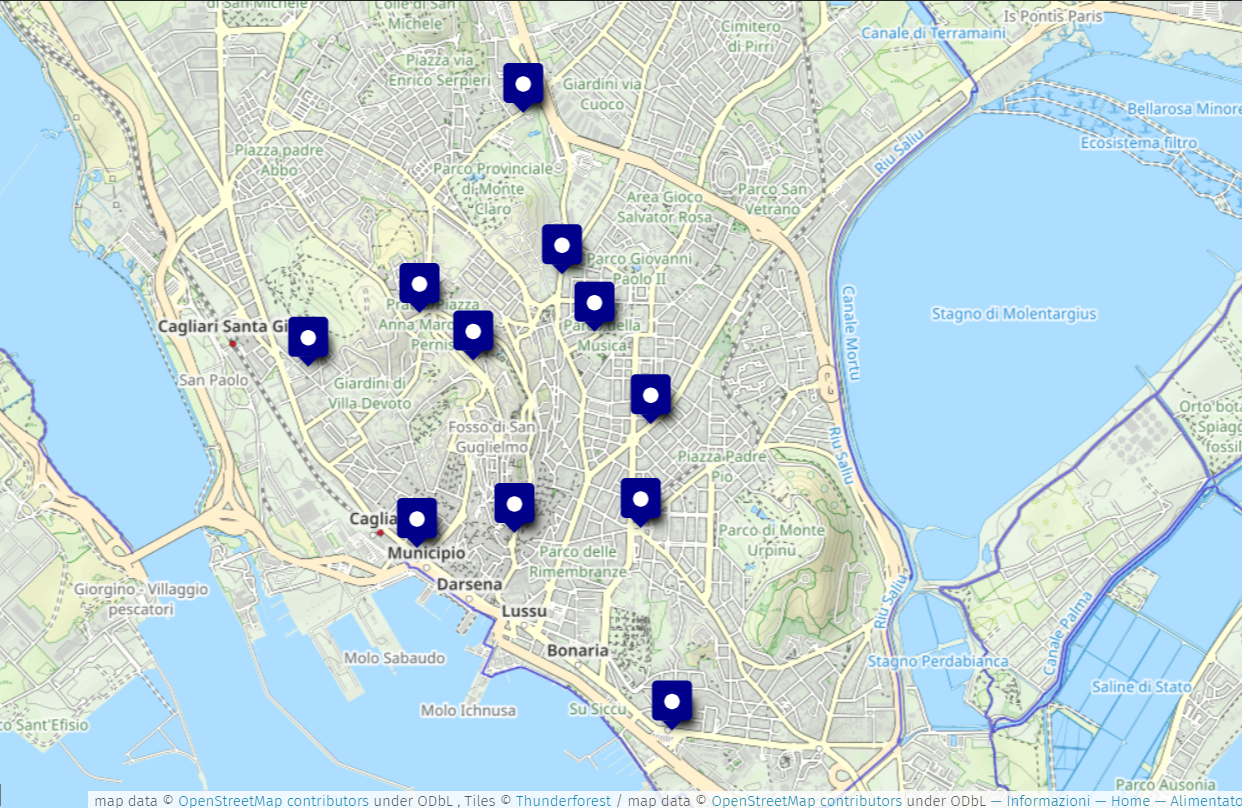

In [ ]:
#soluzione

## Problema di Maximum Independent Set (MIS)

Usiamo Bloqade per risolvere un problema della teoria dei grafi: Maximum Independent Set (MIS). Dato un grafo con vertici (nodi, in bianco) e degli spigoli tra di loro, trovare MIS significa colorare il sottoinsieme più ampio possibile di vertici non connessi tra loro da spigoli. Il nostro MIS sarà semplicemente un insieme di palline colorate (di rosso) senza spigoli tra loro. Come possiamo risolvere questo problema usando gli atomi?

Proviamo a risolvere questo problema prima su un grafo estratto da un reticolo e, successivamente, sul caso reale della mappa delle piazze a Cagliari per trovare le posizioni ottimali per installare le colonnine di ricarica delle batterie per le auto elettriche.  



Per codificare il nostro problema, supponiamo che gli stati a |0⟩ siano bianchi e quelli a |1⟩ siano rossi. Al passo 1 defininiamo le posizioni degli atomi che sono i nodi di un grafo. Per predisporli, possiamo scegliere per semplicità un reticolo 4×4, con distanziamento atomico di 4.5𝜇𝑚 e un drop-out casuale del 20% delle posizioni per rendere le cose più interessanti.


In [ ]:
Random.seed!(2)
a=4.5
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

Ora passiamo a un __caso realistico__, e carichiamo una lista di coordinate di punti della città in cui potremmo installare delle stazioni di ricarica per auto elettriche, in modo da determinare la configurazione ideale del numero minimo di stazioni che copra meglio il territorio tra i punti individuati. 
Per cui, creiamo le funzioni necessarie e carichiamo il file csv che contiene questi punti.

In [ ]:
using CSV
using DataFrames

df=CSV.read("small_subset.csv", DataFrame)
print(df)


z=[ (row["lat"],row["lon"])  for row in eachrow( df ) ];

Visualizziamo la lista di punti della città in un grafico cartesiano

In [ ]:
using Plots
using Geodesy
  
xylla=[ LLA(latlon[1],latlon[2] , 0.0)  for (i, latlon) in enumerate(z) ]

xyutm=[ UTMZ(latlon, wgs84) for (i, latlon) in enumerate(xylla) ]

xy=[ [myutm.x, myutm.y] for (i, myutm) in enumerate(xyutm) ]
print(xy)

In [ ]:

y=[ val[2] for (i, val) in enumerate(xy)]
x=[ val[1] for (i, val) in enumerate(xy)]
df[!, "x"] = x;
df[!, "y"] = y;



Ora riscaliamo le coordinate di questi punti in modo che abbiano posizioni consone per dei siti per gli atomi neutri.

In [ ]:
minX = minimum(x);
maxX = maximum(x);
minY = minimum(y);
maxY = maximum(y);

scaleP=maxX-minX
#Attribuiamo noi il fattore di scala 
my_scale=15.0
x_resc=my_scale*(x.-minX)./scaleP

y_resc=my_scale*((maxY-minY).-(y.-minY))./scaleP
dim=11
c = distinguishable_colors(dim)


dy = diff([extrema(y_resc)...])[1]/20  # adjust offset if needed
scatter(x_resc, y_resc, c=c, ms=7, legend=false, aspect_ratio=1, yflip=true)
[annotate!(x, y+dy, Plots.text(string(i), c[i], 12)) for (i,x, y) in zip(1:dim,x_resc,y_resc)];
display(plot!())

myvector= [(round(xp, digits=1),round(yp, digits=1) )   for (i,xp, yp) in zip(1:dim,x_resc,y_resc)];


In [ ]:
atom_coordinate = AtomList(myvector);

In [ ]:
atom_coordinate

Abbiamo ottenuto in questo modo i nodi/vertici di un grafo. 

La domanda è: come definiamo gli spigoli? 

Sappiamo che due atomi che sono troppo vicini non possono essere entrambi in stato |1⟩ (rosso). Per cui, gli atomi che si trovano a distanza più piccola di un "raggio di bloccaggio" $R_b$, sotto il quale due qubit non possono essere contemporaneamente $1$, saranno connessi da uno spigolo. 

Determiniamo ora il raggio di bloccaggio $R_b$. E' buona norma determinare per primo un $R_{min}$, un raggio minimo entro il quale gli atomi si bloccano reciprocamente e un $R_{max}$, un raggio oltre il quale gli atomi non si bloccano reciprocamente.  Allora, un buon modo per fissare la scala di bloccaggio desiderata è di prendere la media geometrica $R_b=\sqrt{R_{min}R_{max}}$. 

Supponiamo che gli atomi siano connessi con il primo e il secondo vicino. Allora $R_{min}=\sqrt{2}a$ -- blocca il primo e il secondo vicino -- e $R_{max}=2a$ -- non blocca il terzo vicino e gli altri. 

Vogliamo quindi che $R_b=\sqrt{2\sqrt{2}}a\approx 7.57\mu m$.

In [ ]:
Rb=sqrt(2*sqrt(2))*a

Plottiamo il grafo creato in precedenza risultante con questo raggio. 

In [ ]:
Bloqade.plot(atoms, blockade_radius = Rb)

Invece ora plottiamo il grafo che deriva dal caso realistico 

In [ ]:
Bloqade.plot(atom_coordinate, blockade_radius = Rb)

Ora abbiamo il grafo completo. Dobbiomo fissare l'algoritmo e trovare il MIS. 

Per risolvere il MIS nel grafo di sopra, si può scegliere un approccio adiabatico. Aggiungendo un peso globale $\Delta$ a tutti i siti dovrebbe favorire la soluzione in cui tutti i qubit si trovino nello stato $| 1 \rangle$, mentre il raggio di bloccaggio di Rydberg dovrebbe fare, da solo e senza bisogno del nostro controllo, il lavoro di far rispettare il vincolo di non avere nodi rossi vicini. L'avvertenza è che la scelta dei parametri $\Delta$ e $\Omega$ è in realtà legata al raggio di bloccaggio.

Possiamo quindi immaginare di inizializzare il grafo con tutti gli stati colorati di bianco, $|0 \rangle$, e di far evolvere un $\Delta$ globale da un valore molto negativo verso un valore positivo, con un $\Omega$ finito nel frattempo per consentire il salto dello stato dei qubit da $0$ a $1$. Poiché lo stato che stiamo cercando è classico, possiamo anche disattivare $\Omega$ alla fine del protocollo, il che rende più semplice fissare il raggio di bloccaggio: sarà semplicemente definito da $\Delta$ come $R_b = (C_6/\Delta)^{1/6}$, dove $C_6=2\pi \times 862690\, \text{MHz}\, \mu \text{m}^6$. La scelta tipica per $\Omega$ è quella di un valore più grande possibile; esso contribuisce allo scrambling quantistico degli stati attraverso i bit flip e, in un certo senso, definisce la velocità di clock delle operazioni durante il protocollo. Far crescere lentamente $\Delta$ fino al suo valore finale corretto, quindi, definisce un protocollo adiabatico per risolvere il problema MIS.

Ecco come lo facciamo con Bloqade, utilizzando funzioni lineari a tratti per l'evoluzione temporale dei parametri dell'Hamiltoniano.

In [ ]:
#Tempo di evoluzione totale
T_max = 0.6

#Fissiamo Δ secondo il raggio di Rydberg desiderato
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6

#Costruiamo gli andamenti temporali per l'algoritmo adiabatico
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
ϕ = piecewise_constant(clocks=[0.0,T_max], values= [0.0]);

#Un plot veloce per controllo
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

L'ottimizzazione di queste tracce temporali può migliorare la convergenza e la probabilità di trovare il MIS, ma per ora è sufficiente.


Inizializziamo il problema con i parametri di cui sopra, compreso un registro iniziale "zero_state" per i qubit dell'Hamiltoniano.


In [ ]:
h_lattice = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ = ϕ)
prob = SchrodingerProblem(zero_state(nqubits(h_lattice)), T_max, h_lattice);

In [ ]:
h_reale = rydberg_h(atom_coordinate; Ω = Ω, Δ = Δ, ϕ = ϕ)
prob2 = SchrodingerProblem(zero_state(nqubits(h_reale)), T_max, h_reale);

Emuliamo ora l'evoluzione temporale con la seguente sintassi: 


In [ ]:
emulate!(prob2)

Abbiamo finito. Ora è il momento di godersi il risultati interrogando l'istogramma dei risultati. Ad esempio, i 10 stati di base più probabili che contribuiscono a   $| \psi(t=T_{Max}) \rangle$ sono

In [ ]:
bitstring_hist(prob2.reg; nlargest = 10)

Vediamo già che due di loro hanno probabilità più alta degli altri. Corrispondono a dei Maximum Independent Set?
A questo punto, possiamo verificare a occhio. Qui ci sono alcuni plot delle soluzioni (cioé un grafo colorato secondo le etichette degli stati trovati nell'istogramma qui sopra.

Prima plottiamo la prima soluzione corrispondente all'istogramma con probabilità massima e poi cerchiamo di capire a che nodi corrisponde.

In [ ]:
best_bit_strings = most_probable(prob2.reg, 2)

Bloqade.plot(atom_coordinate, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

Ora vediamo a che nodi corrisponde la prima soluzione del MIS. Estraiamo i punti corrispondenti in un altro dataframe.

In [ ]:
bb1=string(best_bit_strings[1]; base=2)
mypos =findall.( x -> x .== '0', bb1);
print(mypos)
dfres1=df[Not(mypos), :]

Processiamo ora la soluzione che abbiamo trovato nell'istogramma con probabilità leggermente inferiore rispetto alla prima

In [ ]:

Bloqade.plot(atom_coordinate, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])


In [ ]:
print(best_bit_strings[2])

bb2=string(best_bit_strings[2]; base=2);

Estraiamo in un dataframe i nomi dei siti corrispondenti a questa nuova soluzione

In [ ]:
mypos2 =findall.( x -> x .== '0', bb2)
print(mypos2)
dfres2=df[Not(mypos2), :]

Abbiamo visto che la soluzione quantistica è intrinsecamente multimodale, cioé fornisce più soluzioni ottimali o subottimali per lo stesso problema computazionale.

E' ora di plottare la soluzione 1 sulla mappa. Carichiamo alcuni pacchetti utili.

In [ ]:
 Pkg.add("OpenStreetMapX");

In [ ]:
using OpenStreetMapX
map_data = get_map_data("map");

println("The map contains $(length(map_data.nodes)) nodes")

In [ ]:
Pkg.add("OpenStreetMapXPlot")

In [ ]:
using OpenStreetMapXPlot
import Plots

llasol1=[ OpenStreetMapX.LLA(row["lat"], row["lon"], 0.)  for row in eachrow( dfres1 ) ]


In [ ]:
psol1=[ OpenStreetMapX.point_to_nodes(lla1, map_data) for (i, lla1) in enumerate(llasol1)]
Plots.gr()
p = OpenStreetMapXPlot.plotmap(map_data,width=600,height=600);
plot_nodes!(p, map_data, 
    psol1;
    color="darkgreen", 
    fontsize=10)
p 
display(p)

Ora plottiamo sulla mappa la soluzione 2

In [ ]:
llasol2=[ OpenStreetMapX.LLA(row["lat"], row["lon"], 0.)  for row in eachrow( dfres2 ) ]

psol2=[ OpenStreetMapX.point_to_nodes(lla1, map_data) for (i, lla1) in enumerate(llasol2)]
Plots.gr()
p = OpenStreetMapXPlot.plotmap(map_data,width=600,height=600);
plot_nodes!(p, map_data, 
    psol2;
    start_numbering_from=1, 
    color="darkgreen", 
    fontsize=10)
p 
display(p)